In [1]:
#imports and pip installs
%pip install -q pandas numpy matplotlib seaborn sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection, metrics  
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
#Plot library
import seaborn as sns
sns.set()

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


In [2]:
#functions definitions

#changes pdays column into 2 columns: one defualt, and other when pdays=999
def change_pdays(df):
    pdays_map = {}
    pdays999_map = {}
    outcomes= df['pdays'].unique()
    for x in df['pdays'].unique():
        pdays_map[x] = x
        pdays999_map[x] = 0
    pdays_map[999] = 0
    pdays999_map[999] = 1
    df['pdays999'] = df['pdays'].map(pdays999_map)
    df['pdays'] = df['pdays'].map(pdays_map)
#changes date to number and maps y to values.
def change_dates_and_map_y(df):
    yes_map = {'yes':1, 'no':0, 'unknown':-1}
    df['y'] = df['y'].map(yes_map)
    df['birth_date'] = [(datetime(2019, 12, 12) - datetime.strptime(x, "%Y-%m-%d")).days/7000 - 2 for x in df['birth_date']]
    df['contact_date'] = [(datetime.strptime(x, "%Y-%m-%d") - datetime(2007, 1, 12)).days/700 for x in df['contact_date']]
    return
# one hot encoding of categorical columns
def create_extra_column (column_name, df):
    outcomes = df[column_name].unique()
    print(outcomes)
    for x in outcomes:
        my_map = {}
        for y in outcomes:
            if(x != y):
                my_map[y] = 0
            my_map[x] = 1
        df[column_name + ' '+x] = df[column_name].map(my_map)
def to_file(filename, y_prediction, df_test):
    res = pd.DataFrame()
    res['id'] = df_test['id']
    res['y'] = y_prediction
    res.to_csv(path_or_buf='{}.csv'.format(filename), index=False, header=True)
    print(res)
def PolynomialFeatures(fd, column_name, power):
    fd[column_name+str(power)] = fd[column_name]**power
def plot_data(column, data, test):
    sns.countplot(y=column, data=data, order=data[column].value_counts().index)
    plt.show()
    sns.countplot(y=column, data=test, order=test[column].value_counts().index)
    plt.show()

# Some data visualization

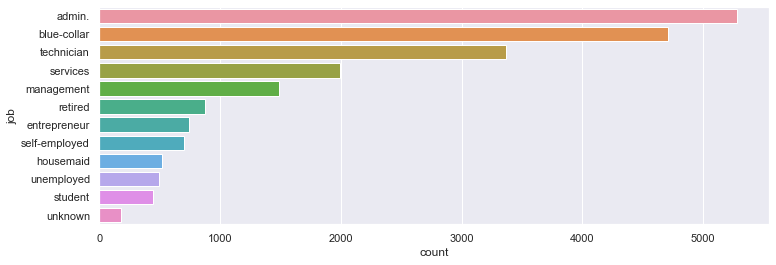

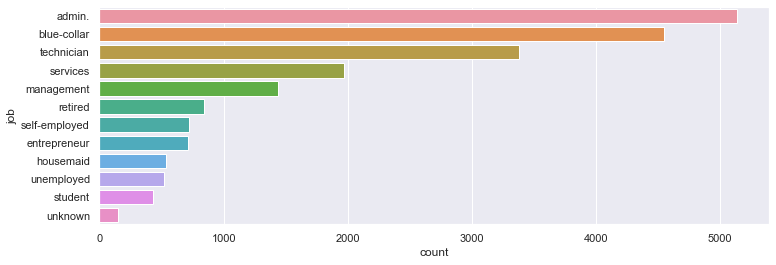

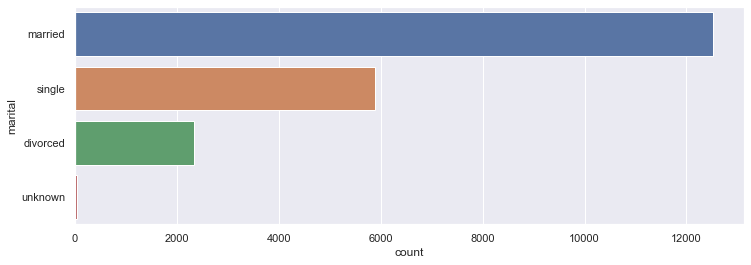

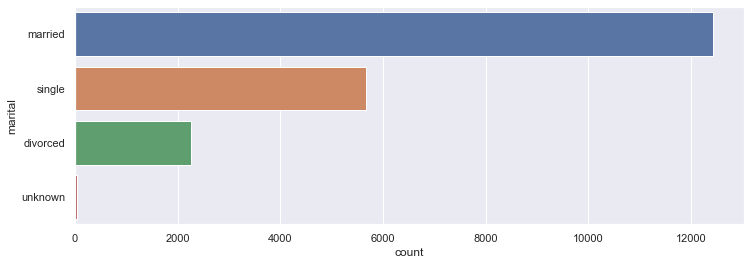

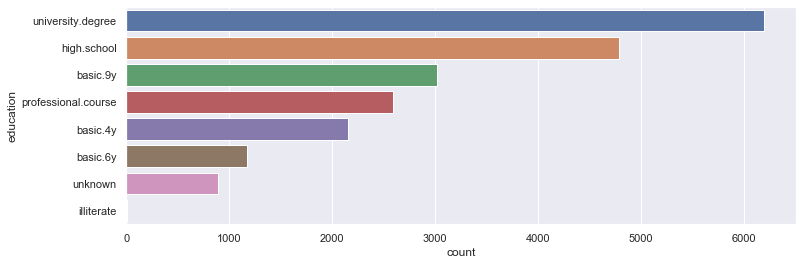

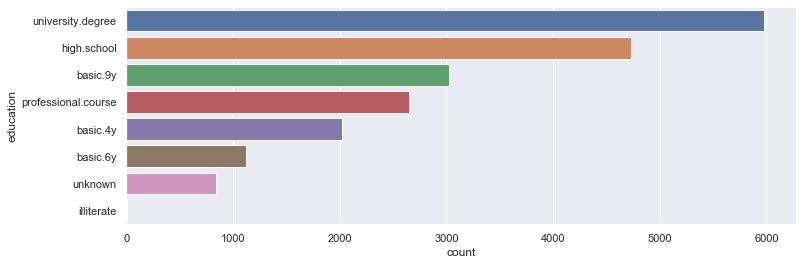

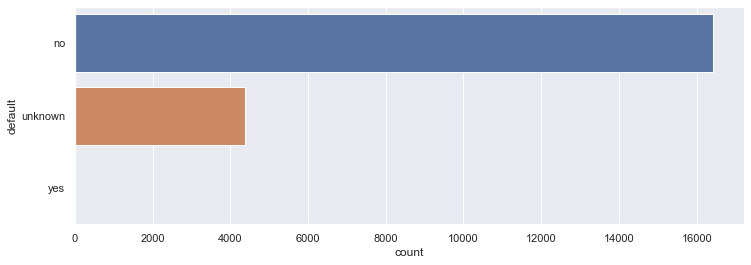

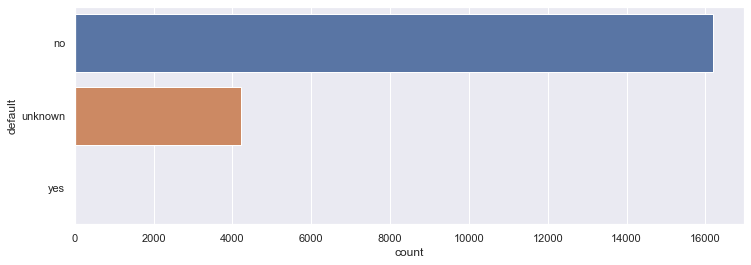

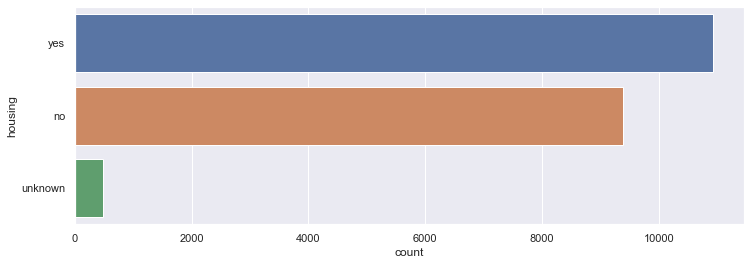

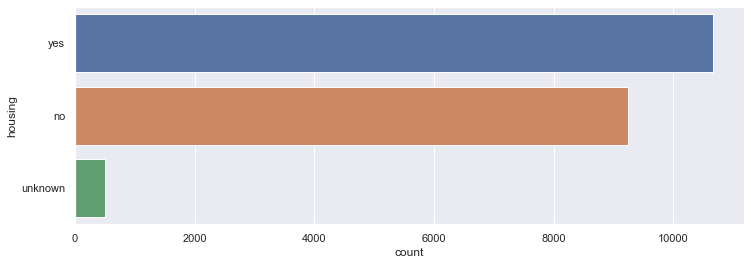

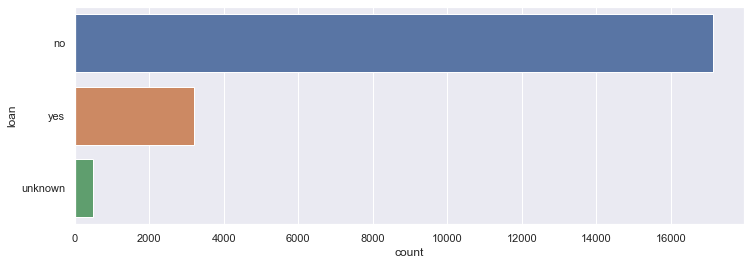

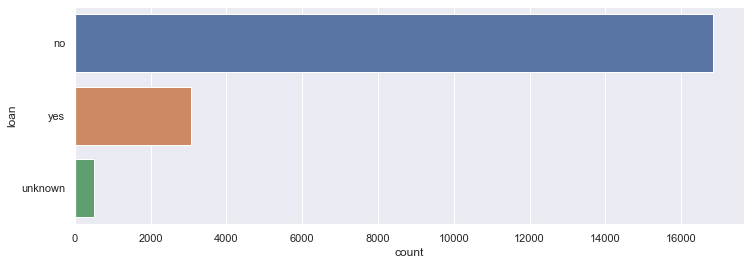

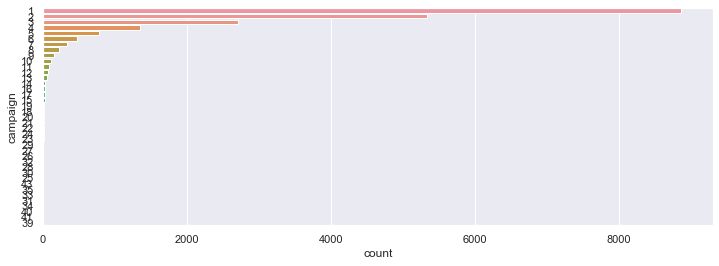

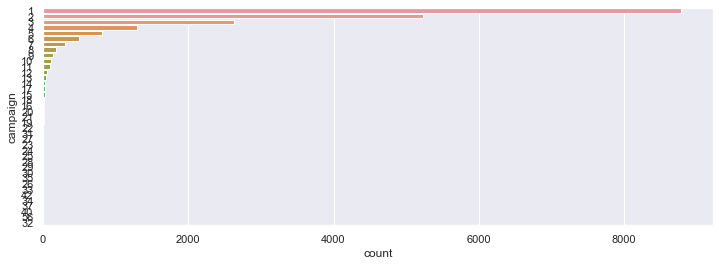

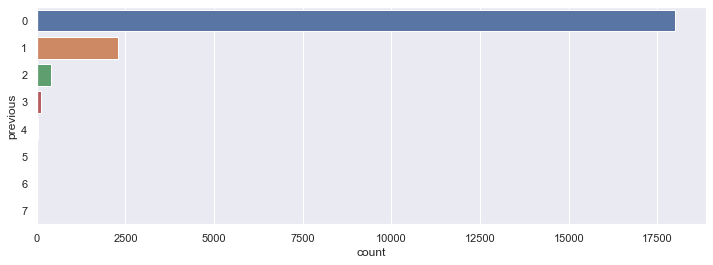

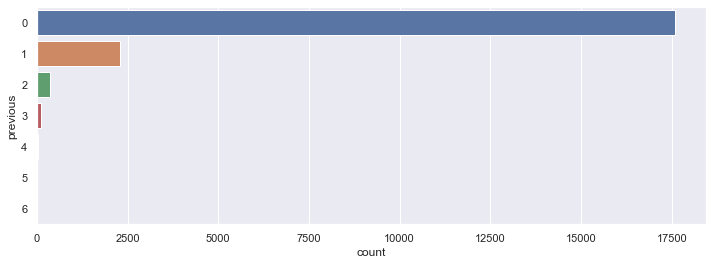

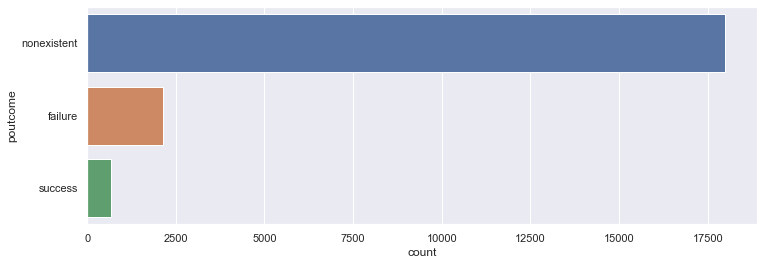

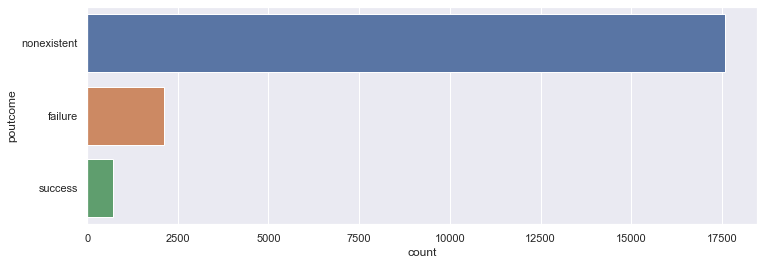

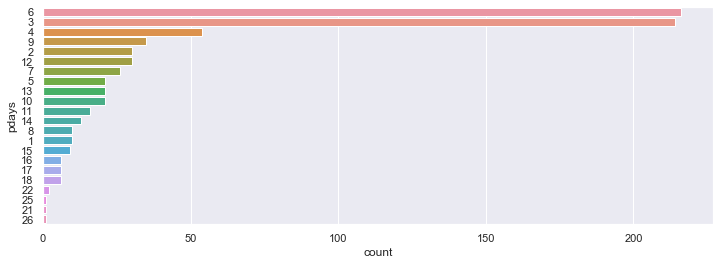

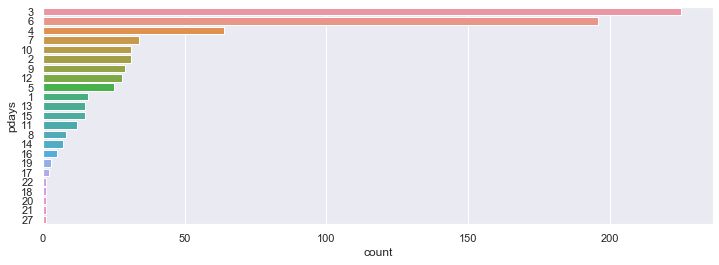

In [8]:
#Let's check the data
df = pd.read_csv('bank/bank-classification.csv', delimiter=',')

change_dates_and_map_y(df)
change_pdays(df)
train_df = df.loc[(df['y'] >= 0 )]
test_df = df.loc[df['y'] == -1]
for x in ['job', 'marital', 'education', 'default',
          'housing', 'loan', 'campaign', 'previous', 'poutcome']:
    plot_data(x, train_df, test_df)
plot_data('pdays', train_df.loc[train_df['pdays']>0], test_df.loc[test_df['pdays']>0])

In [3]:
#some more function definitions here
# integer encoding instead of one hot encoding and with hyperparameters tuned.
def categories_to_int(df, column_name):
    outcomes = df[column_name].unique()
    i = 1
    df_map = {}
    for x in outcomes:
        df_map[x] = i
        i+=1
    df[column_name] = df[column_name].map(df_map)
    
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['y'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain['y'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['y'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['y'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - {:>7g} | Std - {:>7g} | Min - {:>7g} | Max - {:>7g}" \
               .format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


# First solution - Gradient boosting model with integer encoding


Model Report
Accuracy : 0.9178
AUC Score (Train): 0.854985
CV Score : Mean - 0.270836 | Std - 0.337057 | Min -       0 | Max - 0.77177
          id         y
1          2  0.022447
3          4  0.021989
4          5  0.019246
6          7  0.020031
9         10  0.027147
...      ...       ...
41179  41180  0.260923
41180  41181  0.621927
41183  41184  0.283208
41184  41185  0.344222
41186  41187  0.561331

[20389 rows x 2 columns]


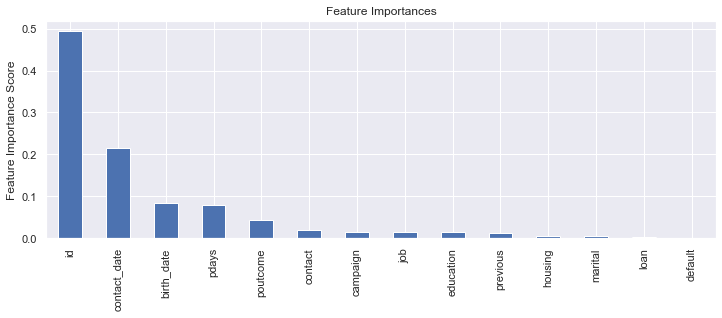

In [68]:

df = pd.read_csv('bank/bank-classification.csv', delimiter=',')
to_int_table = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
                  'poutcome']
for x in to_int_table:
    categories_to_int(df, x)
change_dates_and_map_y(df)

known_data = df.loc[df['y']>=0]
known_data_y = known_data['y']
known_data_train = known_data.drop('y', axis=1)
test_data_with_id = df.loc[df['y']<0]
test_data_with_id = test_data_with_id.drop('y', axis=1)

train = known_data
target ='y'
IDcol= 'y'
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(learning_rate=0.1,
                                  random_state=10,
                                  n_estimators=115,
                                   min_samples_split=10,
                                   min_samples_leaf=5,
                                   max_depth=5,
                                  max_features=8,
                                  subsample=1,)
modelfit(gbm0, train, predictors)
y_pred = gbm0.predict_proba(test_data_with_id)
y_pred[:,1]
#printing to csv file if reproduction is needed
#to_file('gbc5', y_pred[:,1], test_data_with_id)


In [60]:
param_test1 = {'n_estimators':range(40,141,10), 'max_depth':range(3, 9, 2)}
predictors = [x for x in train.columns if x not in [target, IDcol]]
gsearch1 = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                                min_samples_split=9,
                                                                min_samples_leaf=4,
                                                                max_depth=8,
                                                               max_features=8,
                                                               subsample=0.8,
                                                               random_state=1), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, gsearch1.best_score_,

({'max_depth': 3, 'n_estimators': 70}, 0.30238474891115474)

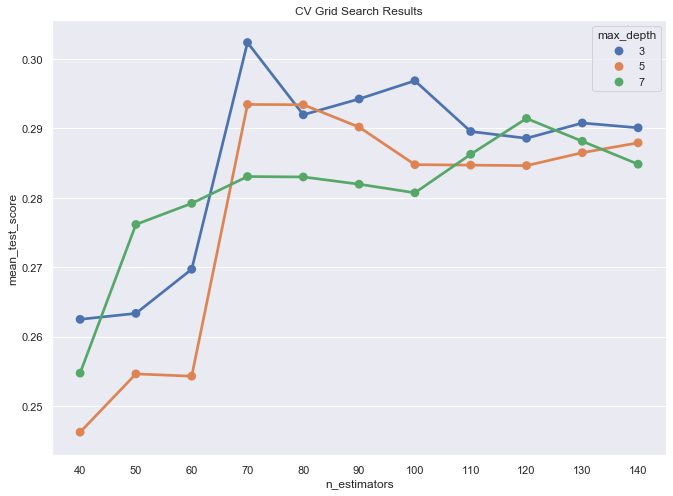

In [61]:
def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig
fig = plot_cv_results(gsearch1.cv_results_, 'n_estimators', 'max_depth')


Model Report
Accuracy : 0.928
AUC Score (Train): 0.870800
CV Score : Mean - 0.267929 | Std - 0.328139 | Min -       0 | Max - 0.671816


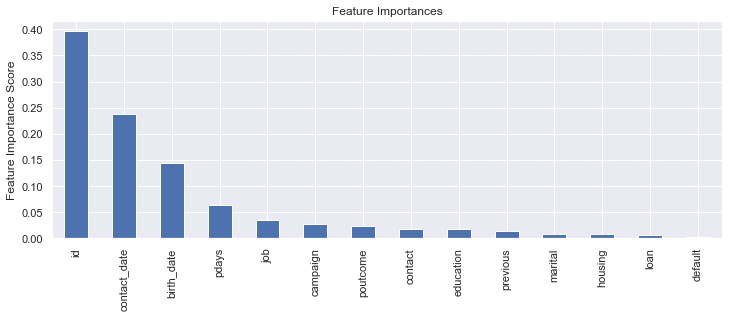

In [11]:
modelfit(gsearch1.best_estimator_, train, predictors )

In [110]:
param_test2 = {'max_depth':[3, 5, 7], 'min_samples_split':range(5, 16, 5)}
predictors = [x for x in train.columns if x not in [target, IDcol]]
gsearch2 = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               min_samples_leaf=5,
                                                               n_estimators=115,
                                                               subsample=0.5,
                                                               random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_samples_split': 15}, 0.25898036453785145)


Model Report
Accuracy : 0.9083
AUC Score (Train): 0.810852
CV Score : Mean - 0.25898 | Std - 0.326225 | Min -       0 | Max - 0.768105


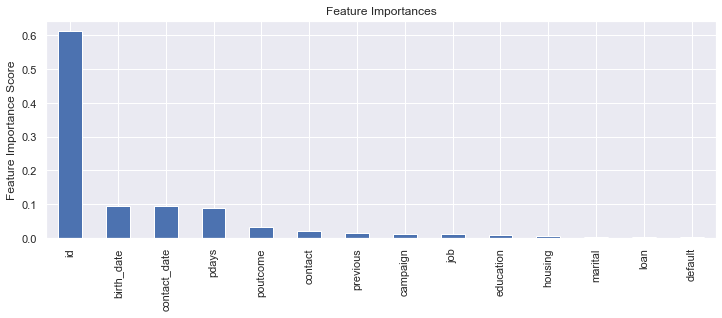

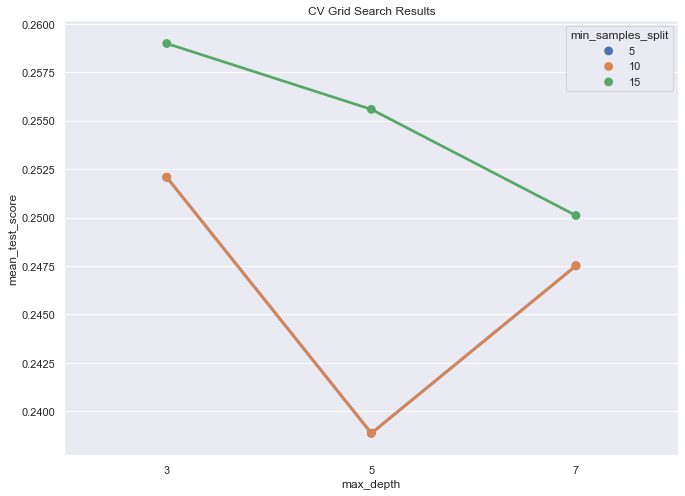

In [111]:
#we can see that 'best_params_' overfits to id feature too much
modelfit(gsearch2.best_estimator_, train, predictors )
fig = plot_cv_results(gsearch2.cv_results_, 'max_depth', 'min_samples_split')

In [62]:
param_test3 = {'min_samples_split':range(1,15,2), 'min_samples_leaf':range(1,10,1)}

gsearch3 = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                                               n_estimators=115,
                                                                               max_depth=5,
                                                                               subsample=0.8, 
                                                                               random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 2, 'min_samples_split': 13}, 0.2915930623483826)


Model Report
Accuracy : 0.9198
AUC Score (Train): 0.852774
CV Score : Mean - 0.291593 | Std - 0.357147 | Min -       0 | Max - 0.736007


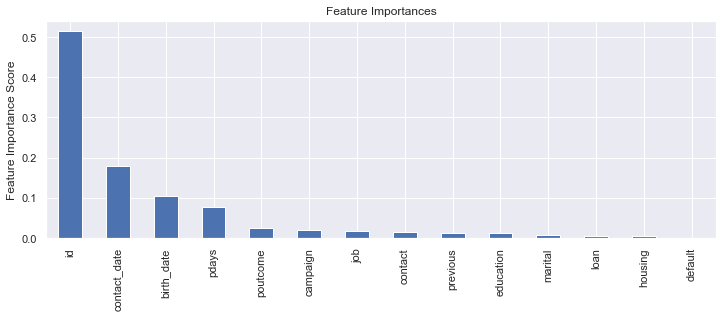

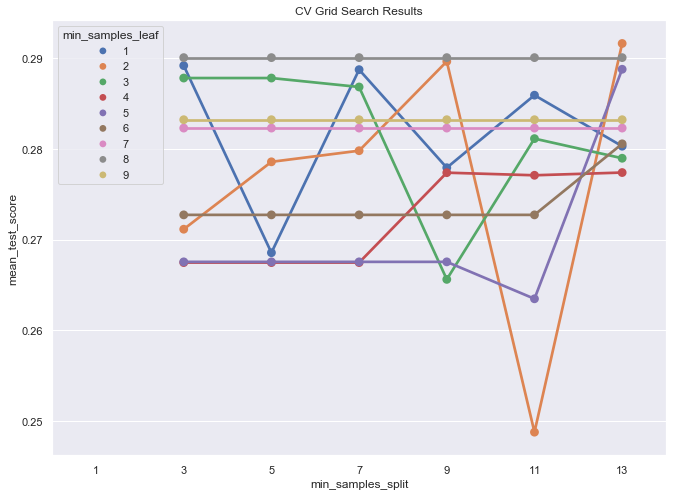

In [65]:
modelfit(gsearch3.best_estimator_, train, predictors )
fig = plot_cv_results(gsearch3.cv_results_, 'min_samples_split', 'min_samples_leaf')

# Second GB model - using one-hot encoding with only subset of columns included.

In [69]:
from datetime import date, datetime
df = pd.read_csv('bank/bank-classification.csv', delimiter=',')
binary_values = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
                  'poutcome']
df['birth_date'] = [(datetime(2019, 12, 12) - datetime.strptime(x, "%Y-%m-%d")).days/7000 - 2 for x in df['birth_date']]
df['contact_date'] = [(datetime.strptime(x, "%Y-%m-%d") - datetime(2009, 1, 12)).days/700 for x in df['contact_date']]

#one hot encoding
for x in binary_values:
    create_extra_column(x, df)
    df = df.drop(x, axis=1)

#split into test and training sets
yes_map = {'yes':1, 'no':0, 'unknown':-1}
df['y'] = df['y'].map(yes_map)
test_df = df.loc[df['y'] == -1]
train_df = df.loc[(df['y'] >= 0 )]

y = train_df['y']
test_df = test_df.drop('y', axis=1)

['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
['married' 'single' 'divorced' 'unknown']
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
['no' 'unknown' 'yes']
['no' 'yes' 'unknown']
['no' 'yes' 'unknown']
['telephone' 'cellular']
['nonexistent' 'failure' 'success']


In [70]:
a = train_df.loc[:, ['id', 'campaign','previous', 'loan yes', 'default no', 'housing yes', 
                     'contact_date','birth_date', 'marital single', 'marital married',
                     'education basic.4y', 'education high.school', 'education basic.6y', 'education basic.9y',
                     'education professional.course', 'education university.degree',
                     'poutcome success','poutcome nonexistent', 'pdays', 'contact cellular', 'job unemployed', 'job management']]
test = test_df.loc[:, ['id', 'campaign','previous', 'loan yes', 'default no',
                       'housing yes', 'contact_date','birth_date', 'marital single', 'marital married',
                       'education basic.4y', 'education high.school', 'education basic.6y','education basic.9y',
                       'education professional.course', 'education university.degree',
                       'poutcome success','poutcome nonexistent', 'pdays', 'contact cellular', 'job unemployed', 'job management']]


Model Report
Accuracy : 0.9154
AUC Score (Train): 0.856220
CV Score : Mean - 0.303364 | Std - 0.375763 | Min -       0 | Max - 0.847439
          id         y
1          2  0.020108
3          4  0.022700
4          5  0.023898
6          7  0.022553
9         10  0.030545
...      ...       ...
41179  41180  0.210023
41180  41181  0.499073
41183  41184  0.244374
41184  41185  0.367086
41186  41187  0.674858

[20389 rows x 2 columns]


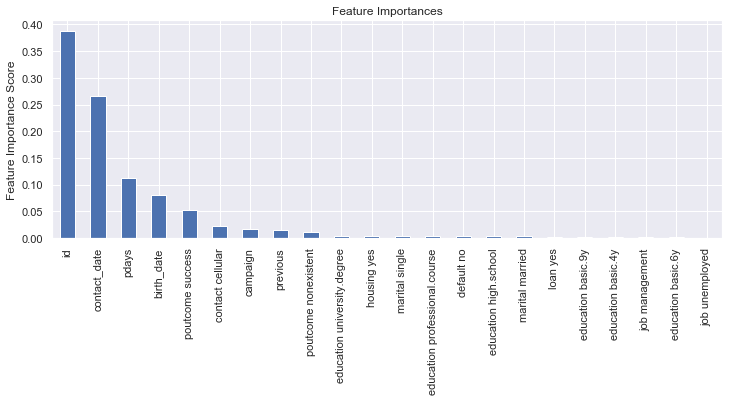

In [87]:
gbm = GradientBoostingClassifier(learning_rate=0.01,
                                  random_state=10,
                                  n_estimators=1200,
                                   min_samples_split=10,
                                   min_samples_leaf=5,
                                   max_depth=5,
                                  max_features=8,
                                  subsample=1,)
preds = [x for x in a.columns if x not in [IDcol, target]]
modelfit(gbm, train_df, preds)
y_pred = gbm.predict_proba(test)
#saving result to csv
#to_file('gbc10', y_pred[:,1], test)



# Other models I tried: SGDClassifier, LinearRegression, Random Forests (didn't achieve sensible results)

In [96]:

df = pd.read_csv('bank/bank-classification.csv', delimiter=',')
change_dates_and_map_y(df)
change_pdays(df)
categories = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
                  'poutcome']
for x in categories:
    create_extra_column(x, df)
    df = df.drop(x, axis=1)
#Those columns have very sparse data (about 2-10 people)
df = df.drop(['default yes', 'education illiterate', 'marital unknown'], axis=1)
#let's create some extra columns
PolynomialFeatures(df, "birth_date" , 2)
PolynomialFeatures(df, "birth_date" , 3)
PolynomialFeatures(df, "contact_date" , 2)
PolynomialFeatures(df, "contact_date" , 3)
PolynomialFeatures(df, "pdays" , 2)
PolynomialFeatures(df, "previous", 2)
PolynomialFeatures(df, "campaign", 2)
df

['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
['married' 'single' 'divorced' 'unknown']
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
['no' 'unknown' 'yes']
['no' 'yes' 'unknown']
['no' 'yes' 'unknown']
['telephone' 'cellular']
['nonexistent' 'failure' 'success']


,id,birth_date,contact_date,campaign,pdays,previous,y,pdays999,job housemaid,job services,...,poutcome nonexistent,poutcome failure,poutcome success,birth_date2,birth_date3,contact_date2,contact_date3,pdays2,previous2,campaign2
0,1,1.533571,0.694286,1,0,0,0,1,1,0,...,1,0,0,2.351841,3.606717,0.482033,0.334668,0,0,1
1,2,1.585714,0.714286,1,0,0,-1,1,0,1,...,1,0,0,2.514490,3.987262,0.510204,0.364431,0,0,1
2,3,0.534143,0.684286,1,0,0,0,1,0,1,...,1,0,0,0.285309,0.152396,0.468247,0.320415,0,0,1
3,4,0.707143,0.704286,1,0,0,-1,1,0,0,...,1,0,0,0.500051,0.353608,0.496018,0.349339,0,0,1
4,5,1.526571,0.704286,1,0,0,-1,1,0,1,...,1,0,0,2.330420,3.557553,0.496018,0.349339,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,41184,2.264714,2.010000,1,0,0,-1,1,0,0,...,1,0,0,5.128931,11.615563,4.040100,8.120601,0,0,1
41184,41185,0.878714,2.000000,1,0,0,-1,1,0,0,...,1,0,0,0.772139,0.678489,4.000000,8.000000,0,0,1
41185,41186,1.401143,2.000000,2,0,0,0,1,0,0,...,1,0,0,1.963201,2.750725,4.000000,8.000000,0,0,4
41186,41187,0.752143,2.020000,1,0,0,-1,1,0,0,...,1,0,0,0.565719,0.425501,4.080400,8.242408,0,0,1


In [97]:
train_df = df.loc[df['y']>=0]
test_df = df.loc[df['y']<0]

In [107]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
#Preprocessing
lin_reg = SGDClassifier(loss='log')
y = train_df['y']
X = train_df.drop(['id', 'y'], axis=1)
scaler = StandardScaler()
#scaling values to [0, 1]
scaler.fit(X)
X = scaler.transform(X)
test = test_df.drop(['id', 'y'], axis=1)
test = scaler.transform(test)

lin_reg.fit(X, y)
prediction = lin_reg.predict_proba(test)
#saving result to csv
#to_file('lin_reg_', prediction[:, 1], test_df)

          id         y
1          2  0.013441
3          4  0.029365
4          5  0.025023
6          7  0.046765
9         10  0.022718
...      ...       ...
41179  41180  0.212128
41180  41181  0.437900
41183  41184  0.223634
41184  41185  0.326370
41186  41187  0.372129

[20389 rows x 2 columns]


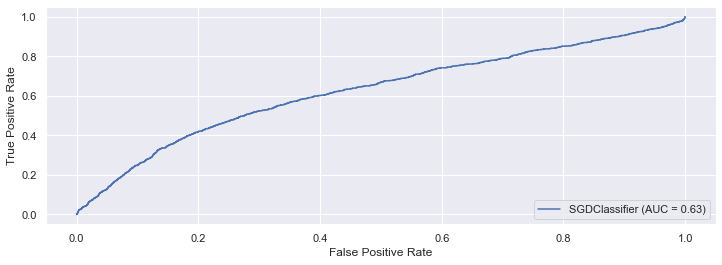

In [109]:
from sklearn import metrics
train_data = X[:15153, :]
train_data_res = y.loc[1:30000]
test_data = X[15154:, :]
test_data_res = y.loc[30001:]
sgdc = SGDClassifier(loss='log')
sgdc.fit(train_data, train_data_res)
metrics.plot_roc_curve(sgdc, test_data, test_data_res)